In [13]:
# Import important libraries

import numpy as np
import sympy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [14]:
a1 = 1
a2 = 1
a3 = 1
a = np.array([a1, a2, a3])

E = 90.588
nu = 0.29412
E_star = 90.588
nu_star = 0.29412

# Self strain of inclusion
eps11 = 0.01
eps22 = 0.01
eps33 = 0.01
eps12 = 0.0
eps13 = 0.0
eps23 = 0.0
eig_strain = np.array([[eps11,eps12,eps13],[eps12,eps22,eps23],[eps13,eps23,eps33]])

# Applied stress at infinity
sig11 = 0
sig22 = 0
sig33 = 0
sig12 = 0
sig13 = 0
sig23 = 0
app_stress = np.array([[sig11,sig12,sig13],[sig12,sig22,sig23],[sig13,sig23,sig33]])

# Strain due to applied stress
eps_11 = sig11/E_star - nu_star*(sig22+sig33)/E_star
eps_22 = sig22/E_star - nu_star*(sig11+sig33)/E_star
eps_33 = sig33/E_star - nu_star*(sig11+sig22)/E_star
eps_12 = sig12*(1+nu_star)/E_star
eps_13 = sig13*(1+nu_star)/E_star
eps_23 = sig23*(1+nu_star)/E_star
app_strain = np.array([[eps_11,eps_12,eps_13],[eps_12,eps_22,eps_23],[eps_13,eps_23,eps_33]])

delta = np.identity(3)

# Calculate meu
meu = E/(2*(1+nu))
meu_star = E_star/(2*(1+nu_star))

# calculate K and K_star and t
K = E/(3*(1-2*nu))
K_star = E_star/(3*(1-2*nu_star))
t = K_star/K

In [15]:
# Solving the cubis equation of lambda (page 86 of Mura's book, equation 11.37)
def get_lambda(x,a):
    sym = sp.Symbol('lambda_')
    equation = (x[0]**2)/(a[0]**2 + sym) + (x[1]**2)/(a[1]**2 + sym) + (x[2]**2)/(a[2]**2 + sym) - 1
    sol =  sp.solve(equation, sym)
    #print("Solution of Lambda: ",sol)

    # Convert sol to complex number
    sol = [complex(i) for i in sol]
    #print(sol)

    # Select the real part of the solution
    sol = [i.real for i in sol]
    #print(sol)
    
    sol = max(sol)
    if sol > 0:
        lambda_ = sol
    else:
        lambda_ = 0
    return lambda_
    #print("lambda = ",lambda_)

In [16]:
# Defining elliptic integrals and solving them. (page 85 of Mura's book, equation 11.36) lambda=0.. verified for lambda = 0
def I_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    def integrand(s):
        return 1/np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))
    inte = integrate.quad(integrand, lambda_, np.inf)[0]
    return inte*np.pi*2*a[0]*a[1]*a[2]

def Ii_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    arr = np.zeros(3)
    for i in range(3):
        def integrand(s):
            return (1/(np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))*(a[i]**2 + s)))
        inte = integrate.quad(integrand, lambda_, np.inf)[0]
        arr[i] = inte*np.pi*2*a[0]*a[1]*a[2]
    return arr

def Iij_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    #print("lambda = ",lamb)
    arr = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            def integrand(s):
                return (1/(np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))*(a[i]**2 + s)*(a[j]**2 + s)))
            inte = integrate.quad(integrand, lambda_, np.inf)[0]
            arr[i,j] = inte*np.pi*2*a[0]*a[1]*a[2]
    return arr

In [17]:
# Compute Sijkl (page 88 of Mura's book, equation 11.42)

def get_Sijkl(x,a,I,Ii,Iij):
    Sijkl = np.zeros((3,3,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    t1 = delta[i,j]*delta[k,l]*(2*nu*Ii[i] - Ii[k] + (a[i]**2)*Iij[k,i])
                    t2 = (delta[i,k]*delta[j,l] + delta[i,l]*delta[j,k])*((a[i]**2)*Iij[i,j] - Ii[j] + (1-nu)*(Ii[k] + Ii[l]))
                    Sijkl[i,j,k,l] = (t1+t2)/(8*np.pi*(1-nu))
                    #print("S",i+1,j+1,k+1,l+1," = ",Sijkl[i,j,k,l])
    return Sijkl

In [18]:
# Compute derivatives of elliptic integrals (page 86 of Mura's book, equation 11.39)
# Compute derivative of lambda wrt to 3 directions
def lamb_der(x,a,lambda_):
    arr = []
    #Check if x in inside
    if (x[0]**2/(a[0]**2)) + (x[1]**2/(a[1]**2)) + (x[2]**2/(a[2]**2)) <= 1:
        return [0,0,0]
    denom = (x[0]**2/(a[0]**2 + lambda_)) + (x[1]**2/(a[1]**2 + lambda_)) + (x[2]**2/(a[2]**2 + lambda_))
    for i in range(3):
        num = (2*x[i])/(a[i]**2 + lambda_)
        arr.append(num/denom)
    return arr

# Compute double derivative matrix of lambda
def lamb_der2(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3))
    #Check if x in inside
    if (x[0]**2/(a[0]**2)) + (x[1]**2/(a[1]**2)) + (x[2]**2/(a[2]**2)) <= 1:
        return arr
    denom = (x[0]**2/(a[0]**2 + lambda_)) + (x[1]**2/(a[1]**2 + lambda_)) + (x[2]**2/(a[2]**2 + lambda_))
    for i in range(3):
        for j in range(3):
            num = 2*denom*lambda_der[i]*lambda_der[j] - 2*(x[i])*lambda_der[j]/(a[i]**2 + lambda_) - 2*(x[j])*lambda_der[i]/(a[j]**2 + lambda_)
            arr[i,j] = num/denom
    return arr

#Compute derivative of Ii wrt to j direction
def Ii_j_(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            arr[i,j] = c*lambda_der[j]/((a[i]**2 + lambda_)*del_l)
    return arr

# Compute derivative of Iij wrt to k direction
def Iij_k_(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                arr[i,j,k] = c*lambda_der[k]/((a[i]**2 + lambda_)*(a[j]**2 + lambda_)*del_l)
    return arr

# Compute double partial derivative of Iij wrt to k and l direction
def Iij_kl_(x,a,lambda_,lambda_der,lambda_der2):
    arr = np.zeros((3,3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    arr[i,j,k,l] = (c/((a[i]**2 + lambda_)*(a[j]**2 + lambda_)*(del_l)))*(lambda_der2[k,l] - lambda_der[k]*lambda_der[l]*(1/(a[i]**2 + lambda_) + 1/(a[j]**2 + lambda_) + 0.5*(1/(a[0]**2 + lambda_) + 1/(a[1]**2 + lambda_) + 1/(a[2]**2 + lambda_))))
    return arr

# Compute derivative of Ii wrt to j and k direction
def Ii_jk_(x,a,lambda_,lambda_der,lambda_der2):
    arr = np.zeros((3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                arr[i,j,k] = (c/((a[i]**2 + lambda_)*(del_l)))*(lambda_der2[j,k] - lambda_der[j]*lambda_der[k]*(1/(a[i]**2 + lambda_) + 0.5*(1/(a[0]**2 + lambda_) + 1/(a[1]**2 + lambda_) + 1/(a[2]**2 + lambda_))))
    return arr

In [19]:
# Compute Dijkl (page 87 of Mura's book, equation 11.41)
def get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk):
    Dijkl = np.zeros((3,3,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    t1 = 8*np.pi*(1-nu)*S[i,j,k,l] + 2*nu*delta[k,l]*x[i]*Ii_j[i,j]
                    t2 = (1+nu)*(delta[i,l]*x[k]*Ii_j[k,j] + delta[j,l]*x[k]*Ii_j[k,i] + delta[i,k]*x[l]*Ii_j[l,j] + delta[j,k]*x[l]*Ii_j[l,i])
                    t3 = -delta[i,j]*x[k]*(Ii_j[k,l] + a[i]**2*Iij_k[k,l,l]) - (delta[i,k]*x[j] + delta[j,k]*x[i])*(Ii_j[j,l] - a[i]**2*Iij_k[i,j,l])
                    t4 = -(delta[i,l]*x[j] + delta[j,l]*x[i])*(Ii_j[j,k] - a[i]**2*Iij_k[i,j,k]) - x[i]*x[j]*(Ii_jk[j,l,k] - a[i]**2*Iij_kl[i,j,l,k])
                    Dijkl[i,j,k,l] = (t1+t2+t3+t4)/(8*np.pi*(1-nu))
                    #print("D",i+1,j+1,k+1,l+1," = ",Dijkl[i,j,k,l])
    return Dijkl

In [20]:
# Calculate epsilon tensor (page 85 of Mura's book, equation 11.33)
def get_epsilon(D,app_strain):
    epsilon = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    epsilon[i,j] = epsilon[i,j] + D[i,j,k,l]*app_strain[k,l]
    return epsilon

In [21]:
# Calculate stress tensor for 3D
def get_stress(epsilon,E,nu,app_strain,inside):
    if inside == True:
        epsilon = epsilon - app_strain
    sig11 = (E/((1+nu)*(1-2*nu)))*((1-nu)*epsilon[0,0] + nu*epsilon[1,1] + nu*epsilon[2,2])
    sig22 = (E/((1+nu)*(1-2*nu)))*(nu*epsilon[0,0] + (1-nu)*epsilon[1,1] + nu*epsilon[2,2])
    sig33 = (E/((1+nu)*(1-2*nu)))*(nu*epsilon[0,0] + nu*epsilon[1,1] + (1-nu)*epsilon[2,2])
    sig12 = (E/(1+nu))*epsilon[0,1]
    sig13 = (E/(1+nu))*epsilon[0,2]
    sig23 = (E/(1+nu))*epsilon[1,2]
    return np.array([[sig11,sig12,sig13],[sig12,sig22,sig23],[sig13,sig23,sig33]])

In [22]:
# Calculate strain equivalents
lambda_ = 0
x = 0
I = I_(x,a,lambda_)
Ii = Ii_(x,a,lambda_)
Iij = Iij_(x,a,lambda_)
S = get_Sijkl(x,a,I,Ii,Iij)

# Calculate shear strains
strain11 = 0
strain22 = 0
strain33 = 0
strain12 = (2*(meu-meu_star)*eps_12 + 2*meu_star*eps12)/(4*(meu_star-meu)*S[0,1,0,1] + 2*meu)
strain13 = (2*(meu-meu_star)*eps_13 + 2*meu_star*eps13)/(4*(meu_star-meu)*S[0,2,0,2] + 2*meu)
strain23 = (2*(meu-meu_star)*eps_23 + 2*meu_star*eps23)/(4*(meu_star-meu)*S[1,2,1,2] + 2*meu)
print("strain12 = ",strain12)
print("strain13 = ",strain13)
print("strain23 = ",strain23)

strains = np.array([[strain11,strain12,strain13],[strain12,strain22,strain23],[strain13,strain23,strain33]])

# Formulate a system of equations to solve for strain11, strain22 and strain33
# r*x = b
r = np.zeros((3,3))
b = np.zeros(3)

r[0,0] = (1-t)*S[0,0,0,0] - 1
r[0,1] = (1-t)*S[0,0,1,1]
r[0,2] = (1-t)*S[0,0,2,2]
r[1,0] = (1-t)*S[1,1,0,0]
r[1,1] = (1-t)*S[1,1,1,1] - 1
r[1,2] = (1-t)*S[1,1,2,2]
r[2,0] = (1-t)*S[2,2,0,0]
r[2,1] = (1-t)*S[2,2,1,1]
r[2,2] = (1-t)*S[2,2,2,2] - 1

t1 = (t-1)*eps_11 - t*eps11
t2 = 0
for m in range(3):
    for n in range(3):
        if m != n:
            t2 += (1-t)*S[0,0,m,n]*strains[m,n]
b[0] = t1 - t2

t1 = (t-1)*eps_22 - t*eps22
t2 = 0
for n in range(3):
    if m != n:
        t2 += (1-t)*S[1,1,m,n]*strains[m,n]
b[1] = t1 - t2

t1 = (t-1)*eps_33 - t*eps33
t2 = 0
for m in range(3):
    for n in range(3):
        if m != n:
            t2 += (1-t)*S[2,2,m,n]*strains[m,n]
b[2] = t1 - t2

print("a = ",r)
print("b = ",b)

x = np.linalg.solve(r,b)
print("strain11 = ",x[0])
print("strain22 = ",x[1])
print("strain33 = ",x[2])

strain11 = x[0]
strain22 = x[1]
strain33 = x[2]
strains = np.array([[strain11,strain12,strain13],[strain12,strain22,strain23],[strain13,strain23,strain33]])
print("strains = ",strains)

strain12 =  0.0
strain13 =  0.0
strain23 =  0.0
a =  [[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
b =  [-0.01 -0.01 -0.01]
strain11 =  0.01
strain22 =  0.01
strain33 =  0.01
strains =  [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]


In [23]:
x = np.array([0.5,0,0])

inside = False
# Check if x is inside ellipsoid
if ((x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2) <= 1:
    inside = True

lambda_ = get_lambda(x,a)
print("lambda = ",lambda_)

I = I_(x,a,lambda_)
Ii = Ii_(x,a,lambda_)
Iij = Iij_(x,a,lambda_)
print("I's are done ")

S = get_Sijkl(x,a,I,Ii,Iij)
print("Sijkl is done ")

lambda_der = lamb_der(x,a,lambda_)
lambda_der2 = lamb_der2(x,a,lambda_,lambda_der)
print("lambda derivatives are done ")

Ii_j = Ii_j_(x,a,lambda_,lambda_der)
Iij_k = Iij_k_(x,a,lambda_,lambda_der)
Iij_kl = Iij_kl_(x,a,lambda_,lambda_der,lambda_der2)
Ii_jk = Ii_jk_(x,a,lambda_,lambda_der,lambda_der2)
print("Ii_j, Iij_k, Iij_kl, Ii_jk are done ")

Dijkl = get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk)
print("Dijkl is done ")

epsilon = get_epsilon(Dijkl,strains)
print(epsilon)
print(epsilon-strains)
stress = get_stress(epsilon,E,nu,strains,inside)
print("stress = ",stress)

lambda =  0
I's are done 
Sijkl is done 
lambda derivatives are done 
Ii_j, Iij_k, Iij_kl, Ii_jk are done 
Dijkl is done 
[[0.00611114 0.         0.        ]
 [0.         0.00611114 0.        ]
 [0.         0.         0.00611114]]
[[-0.00388886  0.          0.        ]
 [ 0.         -0.00388886  0.        ]
 [ 0.          0.         -0.00388886]]
stress =  [[-0.85555619  0.          0.        ]
 [ 0.         -0.85555619  0.        ]
 [ 0.          0.         -0.85555619]]


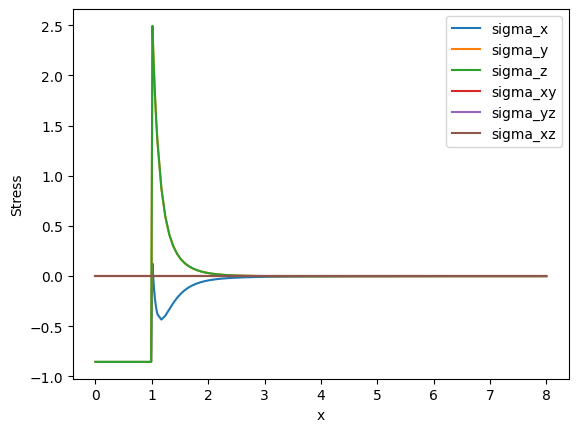

In [24]:
stressx = []
stressy = []
stressz = []
stressxy = []
stressyz = []
stressxz = []

x1 = np.linspace(10e-5,a[0]-10e-2,10)
x2 = np.linspace(a[0]-10e-2,a[0]+10e-2,10)
x3 = np.linspace(a[0]+10e-2,8*a[0],100)
x_p = np.concatenate((x1,x2,x3))


for i in range(len(x_p)):
    x = np.array([x_p[i],0,0])
    inside = False
    # Check if x is inside ellipsoid
    if ((x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2) <= 1:
        inside = True
    lambda_ = get_lambda(x,a)
    I = I_(x,a,lambda_)
    Ii = Ii_(x,a,lambda_)
    Iij = Iij_(x,a,lambda_)
    S = get_Sijkl(x,a,I,Ii,Iij)
    lambda_der = lamb_der(x,a,lambda_)
    lambda_der2 = lamb_der2(x,a,lambda_,lambda_der)
    Ii_j = Ii_j_(x,a,lambda_,lambda_der)
    Iij_k = Iij_k_(x,a,lambda_,lambda_der)
    Iij_kl = Iij_kl_(x,a,lambda_,lambda_der,lambda_der2)
    Ii_jk = Ii_jk_(x,a,lambda_,lambda_der,lambda_der2)
    Dijkl = get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk)
    epsilon = get_epsilon(Dijkl,strains)
    stress = get_stress(epsilon,E,nu,strains,inside)
    stressx.append(stress[0,0])
    stressy.append(stress[1,1])
    stressz.append(stress[2,2])
    stressxy.append(stress[0,1])
    stressyz.append(stress[1,2])
    stressxz.append(stress[0,2])

# Store 6 arrays in a csv file
import pandas as pd
df = pd.DataFrame({'x':x_p,'sigma_x':stressx,'sigma_y':stressy,'sigma_z':stressz,'sigma_xy':stressxy,'sigma_yz':stressyz,'sigma_xz':stressxz})
df.to_csv('analytical.dat', index=False, header=False, sep=' ')

plt.plot(x_p,stressx,label="sigma_x")
plt.plot(x_p,stressy,label="sigma_y")
plt.plot(x_p,stressz,label="sigma_z")
plt.plot(x_p,stressxy,label="sigma_xy")
plt.plot(x_p,stressyz,label="sigma_yz")
plt.plot(x_p,stressxz,label="sigma_xz")
plt.legend()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()